In [1]:

from template_match import read_image_rgb, read_image_gray, template_match, \
    detect_points, find_tolerance_limit, simplify_points, point_to_bbox, agglomerative_clustering, meanshift_clustering

from process_template import template_tresholding, extract_largest_component, find_bbox, \
    crop_image, frame_image, is_grayscale

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [3]:
from ipywidgets import interact, widgets

In [4]:
def draw_image(image: np.ndarray) -> None:
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))


def draw_points_on_canvas(points: np.ndarray, image: np.ndarray) -> None:
    x = points[:, 0]
    y = points[:, 1]
    
    clear_canvas = image.copy()
    clear_canvas[:, :] = 255
    plt.scatter(x, y, alpha=0.5, s=5)
    plt.imshow(cv.cvtColor(clear_canvas, cv.COLOR_BGR2RGB))


from matplotlib.patches import Rectangle

def draw_bbox(x_min, x_max, y_min, y_max, bbox_center=None) -> None:
    height = y_max - y_min
    width = x_max - x_min
    rect = Rectangle((x_min, y_min), width, height, edgecolor='r', facecolor='none')
    ax = plt.gca()
    ax.add_patch(rect)

    if bbox_center:
        bbox_center_x, bbox_center_y = bbox_center
        plt.scatter([bbox_center_x], [bbox_center_y], marker="*")

In [5]:
import os
import pathlib
from typing import List, Tuple
import numpy as np
import cv2 as cv
from sklearn.cluster import AgglomerativeClustering
from dotenv import load_dotenv
from setup_logger import logger


BASE_DIR = pathlib.Path(__name__).resolve().parent.parent
load_dotenv(BASE_DIR / '.env')
DATA_PATH = pathlib.Path(os.getenv("DATA_PATH"))

In [6]:
PLOT_NUMBER = 6
MARKER_NUMBER = 3

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_orig" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

## Step-by-step pipeline

### 1) Draw image and marker

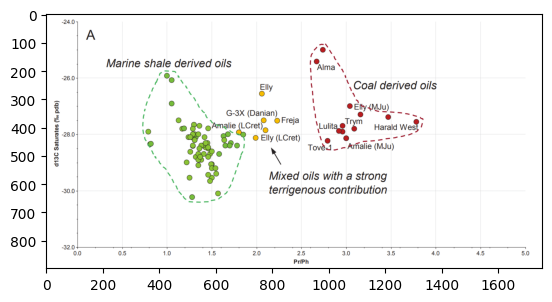

In [7]:
source_image = read_image_rgb(PLOT_PATH)
draw_image(source_image)

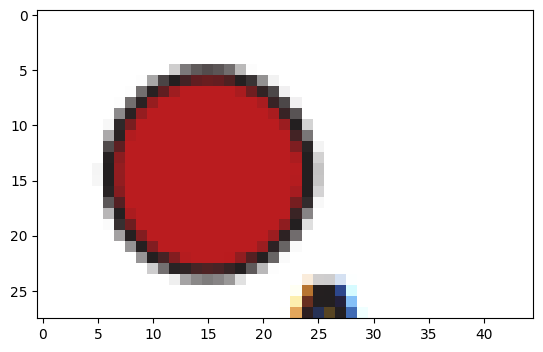

In [8]:
template_rgb = read_image_rgb(TEMPLATE_PATH)
w, h = template_rgb.shape[1], template_rgb.shape[0]

draw_image(template_rgb)

### 2) Template treshholding

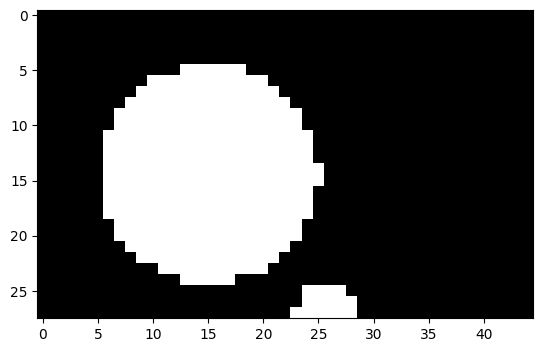

In [9]:
mask = template_tresholding(template_rgb, treshold=200)
draw_image(mask)

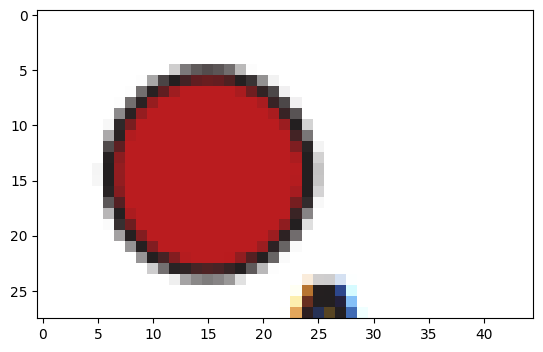

In [10]:
draw_image(template_rgb)
# draw_image(mask)

### 3) Template match, get convolution map

In [11]:
# template_rgb = template_final
# w, h = template_rgb.shape[1], template_rgb.shape[0]

# mask = mask_final

In [12]:
# methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
#            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
# method = 'cv.TM_CCORR_NORMED'
method = 'cv.TM_SQDIFF_NORMED'
# method = 'cv.TM_SQDIFF'


convolution_map, max_val = template_match(source_image, template_rgb, mask, method_name=method)

DEBUG - template_match.py - template_match: Convolution map bounds: (0.0, 1.3531045)
DEBUG - template_match.py - template_match: Convolution map was inverted


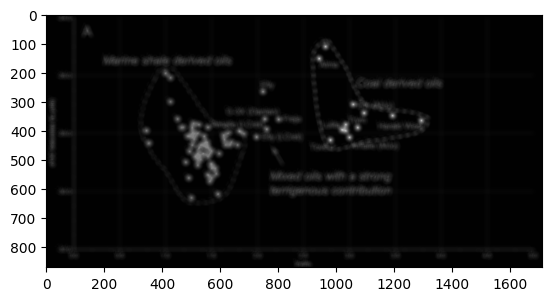

In [13]:
plt.imshow(convolution_map, cmap="gray")

#### Convert point on convolution map to bbox on source image

In [14]:
index = np.where( convolution_map == 1.1025982)

# check
convolution_map[index]

array([1.1025982], dtype=float32)

In [15]:
point_on_map = (index[0][0], index[1][0])

print(index)
print(point_on_map)

(array([398]), array([1020]))
(398, 1020)


In [16]:
bbox = point_to_bbox(*point_on_map, w, h, convolution_map)
x_min, x_max, y_min, y_max = bbox

In [17]:
assert source_image[y_min:y_max+1, x_min:x_max+1].shape == template_rgb.shape

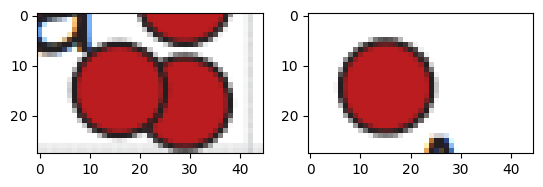

In [18]:
plt.subplot(1, 2, 1)
draw_image(source_image[y_min:y_max+1, x_min:x_max+1])


plt.subplot(1, 2, 2)
draw_image(template_rgb)

### Detect points example

In [19]:
points = detect_points(convolution_map, max_val, tolerance=0.5)
x = points[:, 0]
y = points[:, 1]

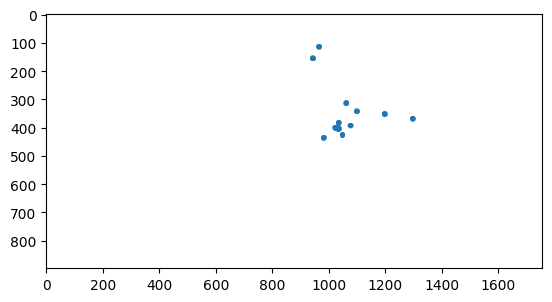

In [20]:
draw_points_on_canvas(points, source_image)

### 4) Find detection tolerance limit

In [21]:
# tolerance_limit = find_tolerance_limit(convolution_map)
# tolerance_limit

In [22]:
# # run detection with limit tolerance value
# points = detect_points(convolution_map, max_val, tolerance=tolerance_limit)
# draw_points_on_canvas(points, source_image)

### Clustering example

In [24]:
eps = 15
cluster_labels = agglomerative_clustering(points, eps)

cluster_centers = simplify_points(points, cluster_labels)

Text(0.5, 1.0, 'Points after clustering and simplification')

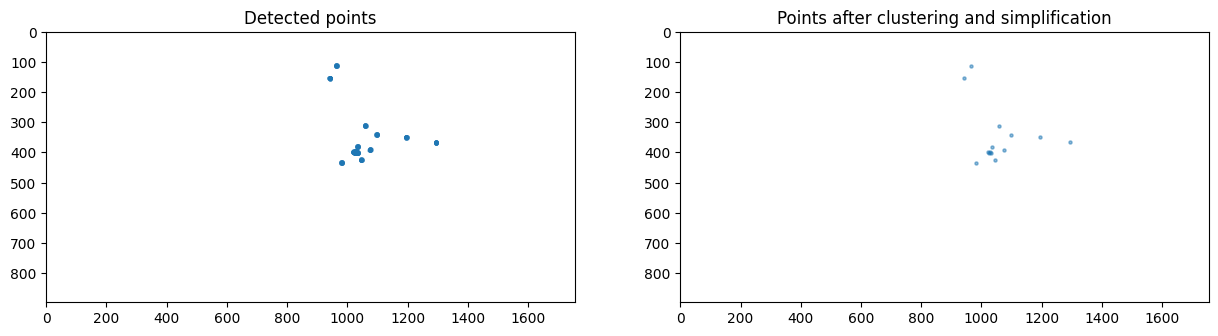

In [30]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
draw_points_on_canvas(points, source_image)
plt.title("Detected points")

plt.subplot(1, 2, 2)
draw_points_on_canvas(cluster_centers, source_image)
plt.title("Points after clustering and simplification")

In [31]:
bw = 4
cluster_labels = meanshift_clustering(points, bandwidth=bw)

cluster_centers = simplify_points(points, cluster_labels)

Text(0.5, 1.0, 'Points after clustering and simplification')

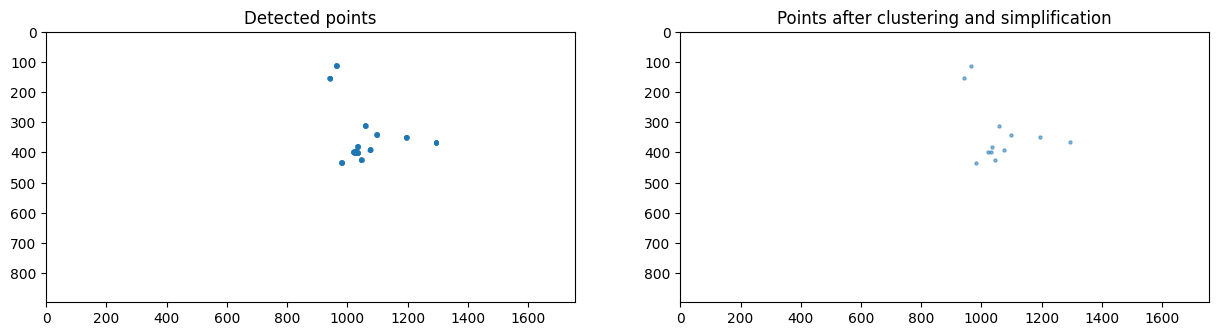

In [32]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
draw_points_on_canvas(points, source_image)
plt.title("Detected points")

plt.subplot(1, 2, 2)
draw_points_on_canvas(cluster_centers, source_image)
plt.title("Points after clustering and simplification")

**Clustering metrics**

In [216]:
# from scipy.spatial import distance
# n = len(points)

# rho = []
# I = []

# for i in range(n):
#     for j in range(i+1, n):
#         dist = distance.euclidean(points[i], points[j])
#         # print(dist)
#         I.append(labels_pred[i] == labels_pred[j])
#         rho.append(dist)

# I = np.array(I)
# rho = np.array(rho)

# I_f0 = I.astype(np.float64)
# I_f1 = 1 - I_f0

In [217]:
# F0 = np.sum(rho * I_f0) / np.sum(I_f0)
# F1 = np.sum(rho * I_f1) / np.sum(I_f1)

# F0, F1, F0 / F1

(18.61327050183725, 172.2479746536529)

### 5) Select best tolerance and eps


Need gloabal variables `convolution_map`, `max_val`, `w`, `h`

In [40]:
@interact(tolerance=widgets.FloatSlider(value=0.01, min=0.01, max=tolerance_limit, step=0.01),
          eps=widgets.FloatSlider(value=1.5, min=1.5, max=15, step=0.5))
def visualize(tolerance, eps):

    points = detect_points(convolution_map, max_val, tolerance=tolerance)

    actual_points = simplify_points(points, eps)
    x = actual_points[:, 0]
    y = actual_points[:, 1]

    ## founded points on original image
    plt.figure(figsize=(10, 6))
    draw_image(source_image)
    x += w // 2 - 1
    y += h // 2 - 1
    plt.scatter(x, y, s=5, c="blue", marker="*")
    plt.xticks([]); plt.yticks([]);
    plt.show()
    
    ## founded points on clear canvas
    plt.figure(figsize=(10, 6))
    draw_points_on_canvas(actual_points, source_image)

interactive(children=(FloatSlider(value=0.01, description='tolerance', max=0.39, min=0.01, step=0.01), FloatSl…

## Step-by-step marker template processing

In [19]:
PLOT_NUMBER = 6
MARKER_NUMBER = 3

# PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_orig" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

### 0) Treshholding

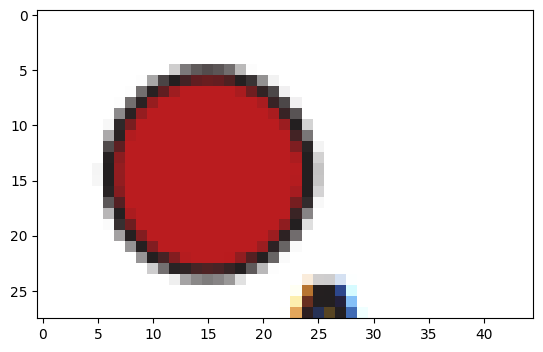

In [20]:
template_rgb = read_image_rgb(TEMPLATE_PATH)
w, h = template_rgb.shape[1], template_rgb.shape[0]

draw_image(template_rgb)

In [21]:
mask = template_tresholding(template_rgb, treshold=200)

In [22]:
### mask for debugging ###

# path_to_mask = str(DATA_PATH / "markers_orig" / "mask_example2.png")
# mask = cv.imread(path_to_mask)

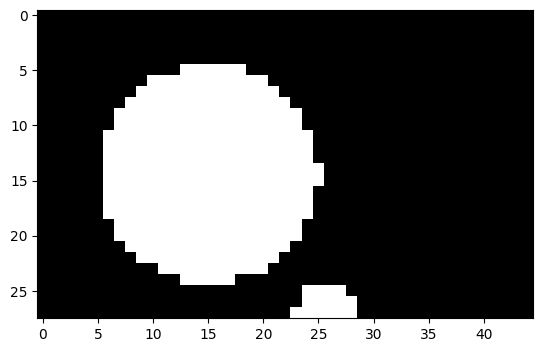

In [23]:
plt.imshow(mask, cmap="gray")

### 1) Find largest connected component

In [24]:
new_mask = extract_largest_component(mask)

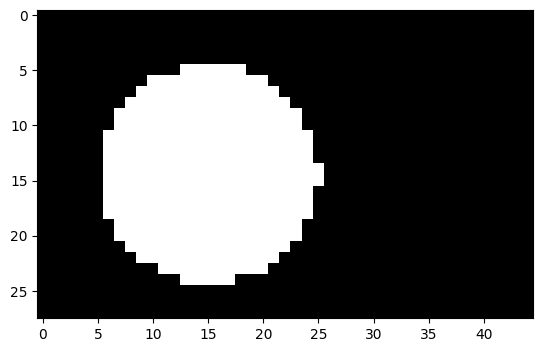

In [25]:
plt.imshow(new_mask, cmap="gray")

### 2) Find bbox around white component

In [42]:
bbox, bbox_center = find_bbox(new_mask)

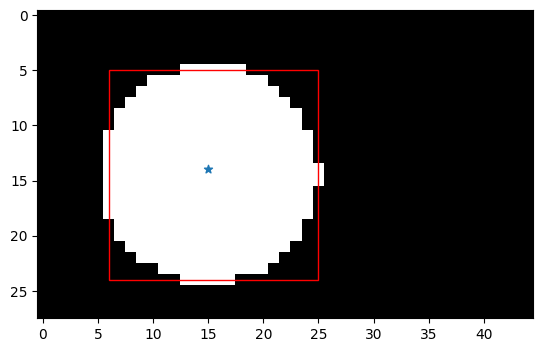

In [44]:
plt.imshow(new_mask, cmap="gray")

draw_bbox(*bbox, bbox_center=bbox_center)

### 3) Crop white component

In [28]:
cropped_mask = crop_image(new_mask, bbox)

cropped_template = crop_image(template_rgb, bbox)

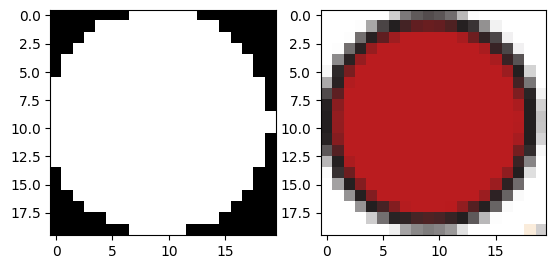

In [29]:
plt.subplot(1, 2, 1)
plt.imshow(cropped_mask, cmap="gray")

plt.subplot(1, 2, 2)
draw_image(cropped_template)

### 4) Add black frames

In [30]:
mask_final = frame_image(cropped_mask, frame_width=2)

template_final = frame_image(cropped_template, frame_width=2)

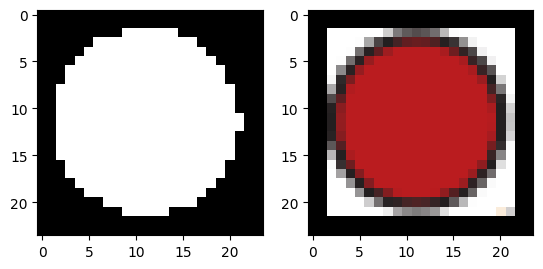

In [31]:
plt.subplot(1, 2, 1)
plt.imshow(mask_final, cmap="gray")

plt.subplot(1, 2, 2)
draw_image(template_final)